In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
!pip uninstall -q tensorflow-quantum
!pip uninstall -q tensorflow

Proceed (y/n)? y
Proceed (y/n)? y


In [7]:
!pip install cirq

     |████████████████████████████████| 593 kB 6.9 MB/s 
     |████████████████████████████████| 48 kB 4.7 MB/s 
     |████████████████████████████████| 56 kB 3.1 MB/s 
     |████████████████████████████████| 52 kB 1.2 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 97 kB 5.7 MB/s 
     |████████████████████████████████| 145 kB 50.5 MB/s 
     |████████████████████████████████| 49 kB 4.8 MB/s 
     |████████████████████████████████| 65 kB 3.1 MB/s 
     |████████████████████████████████| 10.1 MB 49.2 MB/s 
     |████████████████████████████████| 220 kB 74.8 MB/s 
     |████████████████████████████████| 15.7 MB 51.7 MB/s 
     |████████████████████████████████| 229 kB 58.7 MB/s 
     |████████████████████████████████| 44 kB 2.5 MB/s 
     |████████████████████████████████| 38.1 MB 256 kB/s 
     |████████████████████████████████| 243 kB 47.8 MB/s 
     |████████████████████████████████| 1.6 MB 43.3 MB/s 
     |███████████████████████

In [1]:
!pip install -q tensorflow
!pip install -q tensorflow-quantum

     |████████████████████████████████| 497.5 MB 17 kB/s 
     |████████████████████████████████| 462 kB 52.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyquil 3.0.1 requires importlib-metadata<4.0.0,>=3.7.3; python_version < "3.8", but you have importlib-metadata 4.11.3 which is incompatible.


In [2]:
import cirq
import tensorflow as tf
import tensorflow_quantum as tfq

import sympy
import numpy as np
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
from cirq.ops import *

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: cirq.ops.moment was used but is deprecated.
 it will be removed in cirq v0.16.
 Use cirq.circuits.moment instead.

  if sys.path[0] == '':


# Task II: Quantum Generative Adversarial Network (QGAN) Part

You will explore how best to apply a quantum generative adversarial network (QGAN) to solve a High Energy Data analysis issue, more specifically, separating the signal events from the background events. You should use the Google Cirq and Tensorflow Quantum (TFQ) libraries for this task.
A set of input samples (simulated with Delphes) is provided in NumPy NPZ format. In the input file, there are only 100 samples for training and 100 samples for testing so it won’t take much computing resources to accomplish this
task. The signal events are labeled with 1 while the background events are labeled with 0.
Be sure to show that you understand how to fine tune your machine learning model to improve the performance. The performance can be evaluated with classification accuracy or Area Under ROC Curve (AUC).

In [3]:
# Load Dataset
with np.load('/content/drive/MyDrive/Colab Notebooks/ML4SCI Tasks/QIS_EXAM_200Events.npz', allow_pickle=True) as data:
    x_train = data["training_input"].item()
    x_test = data["test_input"].item()

In [4]:
x_train_0 = x_train['0']
x_train_1 = x_train['1']
x_test_0 = x_test['0']
x_test_1 = x_test['1']

x_train = np.concatenate((x_train_0, x_train_1), axis=0)
x_test = np.concatenate((x_test_0, x_test_1), axis=0)
y_train = np.zeros((len(x_train),), dtype=np.int32)
y_train[len(x_train_0):] = 1
y_test = np.zeros((len(x_test),), dtype=np.int32)
y_test[len(x_test_0):] = 1

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(x_train[:10])
print(x_test[:10])

(100, 5) (100, 5) (100,) (100,)
[[-0.43079088  0.86834819 -0.92614721 -0.92662029 -0.56900862]
 [ 0.33924198  0.56155499  0.93097459 -0.91631726 -0.54463516]
 [-0.42888879  0.87064961 -0.92782179 -0.77533991 -0.58329176]
 [-0.43262871  0.86128919 -0.92240878 -0.88048862 -0.49963115]
 [-0.99925345 -0.99949586  0.07753685 -0.84218034 -0.5149399 ]
 [-0.99631106 -0.99775978  0.0756427  -0.54117216 -0.66299335]
 [-0.42645921  0.87141204 -0.92908723 -0.52650143 -0.62187526]
 [ 0.34317906  0.57125045  0.92638556 -0.85113425 -0.40170562]
 [-0.99904849 -0.99933931  0.07737929 -0.81161066 -0.53550246]
 [ 0.3371327   0.55874622  0.92996976 -0.9117092  -0.50996097]]
[[-0.43080401  0.86308617 -0.92383665 -0.7288808  -0.53944676]
 [ 0.33955674  0.5637837   0.92720881 -0.81843942 -0.6058888 ]
 [ 0.88826449 -0.94407139 -0.66863101 -0.75178845 -0.60501115]
 [-0.99698887 -0.99830749  0.07614012 -0.64736972 -0.61107892]
 [-0.42987561  0.86729839 -0.92592964 -0.77358656 -0.45954928]
 [-0.99903924 -0.99940

In [19]:
def generate_circuit(qubits):
  "Generate a random circuit"
  random_circuit = cirq.generate_boixo_2018_supremacy_circuits_v2(qubits, cz_depth=2, seed=1234)
  return random_circuit

def generate_data(circuit, n_samples):
  "Given # of samples from circuit to a tensor"
  return tf.squeeze(tfq.layers.Sample()(circuit, repetitions=n_samples).to_tensor())

In [20]:
n_qubits = 5
n_samples = 100
qubits = cirq.GridQubit.rect(1, n_qubits)
reference_circuit = generate_circuit(qubits)
random_data = generate_data(reference_circuit, n_samples)
print(random_data.shape)
random_data[:10]

(100, 5)


<tf.Tensor: shape=(10, 5), dtype=int8, numpy=
array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1]], dtype=int8)>

In [7]:
def make_generator():
  "Generator"
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(256, use_bias=False, input_shape=(n_qubits,), activation='ReLU'))
  model.add(tf.keras.layers.Dense(128, activation='ReLU'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(64, activation='ReLU'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(n_qubits, activation='tanh'))
  return model


def make_discriminator():
  "Discriminator"
  input = tf.keras.Input(shape=(n_qubits, ), dtype=tf.float32)
  output = tf.keras.layers.Dense(256, use_bias=False, activation='ReLU')(input)
  output = tf.keras.layers.Dense(128, activation='ReLU')(output)
  output = tf.keras.layers.Dropout(0.4)(output)
  output = tf.keras.layers.Dense(64, activation='ReLU')(output)
  output = tf.keras.layers.Dropout(0.3)(output)
  classification = tf.keras.layers.Dense(2, activation='softmax')(output)
  discrimination = tf.keras.layers.Dense(1, activation='sigmoid')(output)
  model = tf.keras.Model(inputs=[input], outputs=[discrimination, classification])
  return model

In [8]:
generator = make_generator()
discriminator = make_discriminator()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)

In [9]:
BATCH_SIZE = 20
cross_entropy_t = tf.keras.losses.BinaryCrossentropy(from_logits=False)

@tf.function
def train_step(images, labels, noise):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
    generated_data = generator(noise, training=True)

    real_output, real_preds = discriminator(images, training=True)
    fake_output, fake_preds = discriminator(generated_data, training=True)

    gen_loss = generator_loss(fake_output)
    dis_loss = discriminator_loss(real_output, fake_output)
    dis_loss = dis_loss + cross_entropy_t(tf.one_hot(tf.squeeze(labels), depth=2), real_preds)
  
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = dis_tape.gradient(dis_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, dis_loss

In [11]:
def train(data, labels, noise, epochs):
  "Training model"
  batched_data = tf.data.Dataset.from_tensor_slices(data).batch(BATCH_SIZE)
  batched_labels = tf.data.Dataset.from_tensor_slices(labels).batch(BATCH_SIZE)
  batched_noise = tf.data.Dataset.from_tensor_slices(noise).batch(BATCH_SIZE)
  AUC = tf.keras.metrics.AUC()
  g_losses = []
  d_losses = []
  for epoch in range(epochs):
    g_epoch_losses = []
    d_epoch_losses = []
    # aucs_epoch = []
    for i, (data_batch, labels_batch, noise_batch) in enumerate(zip(batched_data, batched_labels, batched_noise)):
      gl, dl = train_step(data_batch, labels_batch, noise_batch)
      g_epoch_losses.append(gl)
      d_epoch_losses.append(dl)
    
    g_losses.append(tf.reduce_mean(g_epoch_losses))
    d_losses.append(tf.reduce_mean(d_epoch_losses))
    print('For Epoch: {}, Generator loss: {} and Discriminator loss: {}'.format(epoch, tf.reduce_mean(g_epoch_losses), tf.reduce_mean(d_epoch_losses)))
  return g_losses, d_losses

In [17]:
EPOCHS = 500
gen_losse, dis_losse = train(x_train, y_train, random_data, EPOCHS)

For Epoch: 0, Generator loss: 4.809860706329346 and Discriminator loss: 0.8590350151062012
For Epoch: 1, Generator loss: 4.9820098876953125 and Discriminator loss: 0.867115318775177
For Epoch: 2, Generator loss: 4.841441631317139 and Discriminator loss: 0.7906109690666199
For Epoch: 3, Generator loss: 5.351897239685059 and Discriminator loss: 0.8700622320175171
For Epoch: 4, Generator loss: 5.909662246704102 and Discriminator loss: 0.7579900622367859
For Epoch: 5, Generator loss: 5.450976371765137 and Discriminator loss: 0.8505834341049194
For Epoch: 6, Generator loss: 5.556309700012207 and Discriminator loss: 0.8474451303482056
For Epoch: 7, Generator loss: 4.947591781616211 and Discriminator loss: 0.8580986857414246
For Epoch: 8, Generator loss: 5.128631591796875 and Discriminator loss: 0.9197665452957153
For Epoch: 9, Generator loss: 5.140061378479004 and Discriminator loss: 0.8726819753646851
For Epoch: 10, Generator loss: 5.211541652679443 and Discriminator loss: 0.825836777687072

In [16]:
_, train_pred = discriminator(tf.convert_to_tensor(x_train))
_, test_pred = discriminator(tf.convert_to_tensor(x_test))
binary_accuracy = tf.keras.metrics.BinaryAccuracy()
binary_accuracy.update_state(tf.one_hot(tf.squeeze(y_train), depth=2), train_pred)
print('Train accuracy: %.3f%s'% (binary_accuracy.result().numpy()*100, '%'))
binary_accuracy.update_state(tf.one_hot(tf.squeeze(y_test), depth=2), test_pred)
print('Test accuracy: %.3f%s'% (binary_accuracy.result().numpy()*100, '%'))

Train accuracy: 82.000%
Test accuracy: 76.500%


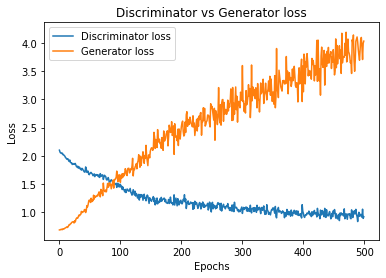

In [14]:
plt.title('Discriminator vs Generator loss')
plt.plot(dis_losse, label='Discriminator loss')
plt.plot(gen_losse, label='Generator loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()